## MNIST Handwritten Digits Classification Experiment

This demo shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs are automatically tracked will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Note this notebook can only be ran on sagemaker notebook instance with `conda_pytorch_p36` kernel.

### Install Python SDKs

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Setup

In [3]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [4]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

### Create a S3 bucket to hold data

In [5]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [6]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 8547008.99it/s]                             


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


32768it [00:00, 469302.37it/s]
  1%|          | 16384/1648877 [00:00<00:10, 148584.26it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


1654784it [00:00, 6640268.06it/s]                           
8192it [00:00, 192965.03it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw
Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


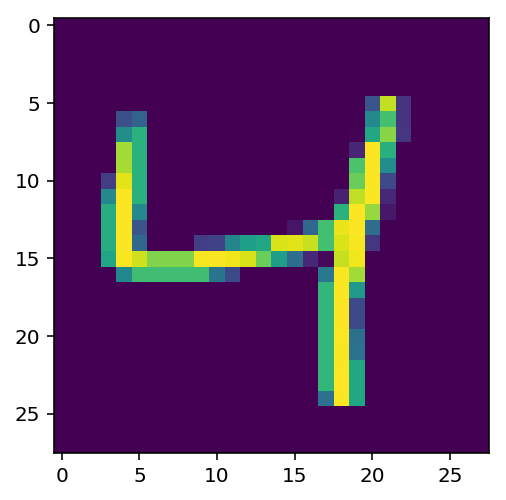

In [7]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [8]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-2-811346863928/mnist


Now lets track the parameters from the data pre-processing step.

In [9]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [10]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fe30d9f2048>,experiment_name='mnist-hand-written-digits-classification-1579675313',description='Classification of mnist hand-written digits',experiment_arn='arn:aws:sagemaker:us-east-2:811346863928:experiment/mnist-hand-written-digits-classification-1579675313',response_metadata={'RequestId': 'c60c030b-3cf3-4555-9fec-4afb91a8ef8e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c60c030b-3cf3-4555-9fec-4afb91a8ef8e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Wed, 22 Jan 2020 06:41:53 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment


### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.

While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [11]:
from sagemaker.pytorch import PyTorch

In [12]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [13]:
preprocessing_trial_component = tracker.trial_component

In [ ]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [15]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [16]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [17]:
analytic_table = trial_component_analytics.dataframe()

In [18]:
analytic_table

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,cnn-training-job-1579675314-aws-training-job,Training,arn:aws:sagemaker:us-east-2:811346863928:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,cnn-training-job-1579676078-aws-training-job,Training,arn:aws:sagemaker:us-east-2:811346863928:train...,0.2,2.0,20.0,"""sgd""",96.0,97.0,96.5,0.707107,97.0,2
2,cnn-training-job-1579675823-aws-training-job,Training,arn:aws:sagemaker:us-east-2:811346863928:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
3,cnn-training-job-1579676333-aws-training-job,Training,arn:aws:sagemaker:us-east-2:811346863928:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
4,cnn-training-job-1579675538-aws-training-job,Training,arn:aws:sagemaker:us-east-2:811346863928:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [19]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [20]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-01-22-064153-masl,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1579675314-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:us-east-2:811346863928:train...,520713654638.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
